![Header Image]( ../assets/header_image.png "Header Image")

# Assignment: Camera-based Semantic Grid Mapping

Welcome to the assignment **Camera-based Semantic Grid Mapping**.

In this assignment, we will use images taken from multiple vehicle-mounted cameras to obtain a **360° bird's eye view (BEV)** of the road.  Our approach makes use of **inverse perspective mapping (IPM)**.

Then, we will apply IPM to semantically segmented images to get a **semantic grid map** of the vehicle's surroundings, as shown in the picture below.

The semantic grid maps are similar to occupancy grid maps and give additional information about what kind of objects are in the environment of a vehicle.

![Example](ipm_assets/images/demo_carla.png "Example")

The semantic grid map we will obtain can make the tasks of planning and prediction easier.

In this assignment we will walk through the following steps:

- Load images, and the camera parameters
- Use OpenCV to apply the inverse perspective mapping
- Use the pinhole camera model
- Apply coordinate system transformations
- Perform IPM
- Stitch multiple images in BEV

Let's start by importing all the necessary packages for this assignment:

In [1]:
import cv2
import numpy as np
import json
import matplotlib.pyplot as plt
import os

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-bbjk5v3m because the default path (/home/jovyan/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
def show_image(img, title=None):
    """this function shows an opencv image in this notebook"""
    rgb_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(rgb_img)
    if title is not None:
        plt.title(title)
    plt.show()

## Example of the Inputs

We will start this assignment by applying **IPM to RGB images** (not segmented) captured by vehicle-mounted cameras in a simulator (VTD). The image loaded by the following code segment was captured by the front right camera of the vehicle. 

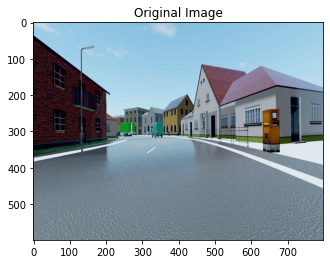

[[[230 209 177]
  [231 210 179]
  [231 210 179]
  ...
  [230 205 155]
  [230 205 155]
  [230 205 155]]

 [[231 210 178]
  [231 210 179]
  [231 210 179]
  ...
  [230 205 155]
  [230 205 155]
  [230 205 155]]

 [[231 210 179]
  [230 210 179]
  [231 211 180]
  ...
  [230 205 155]
  [230 205 155]
  [230 205 155]]

 ...

 [[132 123 109]
  [124 115 101]
  [144 135 121]
  ...
  [125 112  96]
  [126 113  97]
  [130 117 101]]

 [[140 131 117]
  [150 141 127]
  [167 158 144]
  ...
  [129 116 100]
  [132 119 103]
  [134 121 105]]

 [[161 152 138]
  [170 161 147]
  [152 143 129]
  ...
  [140 127 111]
  [141 128 112]
  [138 125 109]]]


In [3]:
# read image
img = cv2.imread("ipm_assets/images/vr_1.png")
# show image 
show_image(img, "Original Image")
print(img)

## Task: Use OpenCV to perform IPM
In this task, you will learn how to use OpenCV to transform an image, taken by a camera, into a BEV image, as shown in the image below. 

![Expected Output](ipm_assets/images/expected_output_warp_persp.png "Expected Output")

This mapping can be achieved using a homogeneous transformation **P** (which we will call `P_cam_to_bev` in our code).
This transformation can map a point (in camera-image coordinates) to road coordinates (BEV coordinates).

Using the **homogeneous** coordinates **x<sub>c<sub>i</sub></sub>** for the camera image and **x<sub>r<sub>i</sub></sub>** for the road, we can map points **x<sub>c<sub>i</sub></sub>** to points **x<sub>r<sub>i</sub></sub>** using a matrix multiplication.


The homogenous transformation **P** is a **projective transformation** and can be written as a **3x3 matrix**:

$$ \large P =  \begin{bmatrix} p_{11} & p_{12} & p_{13} \\ p_{21} & p_{22} & p_{23}\\p_{31} & p_{32} & 1 \end{bmatrix}$$

Points in image coordinates get mapped to road coordinates as follows:

$$ \large \begin{bmatrix} w_i x_{r_i} \\ w_i y_{r_i} \\ w_i \end{bmatrix} = P \begin{bmatrix} x_{c_i} \\ y_{c_i} \\ 1 \end{bmatrix}$$


Using the equation above and by knowing **four source points in the image** coordinates and their **corresponding four points in the road coordiantes** we can solve a system of equations for the 8 unknown parameters of **P**. 

Thankfully, OpenCV provides a method to do this!

Using `cv2.getPerspectiveTransform()`, which takes `source_coordinates` (**x<sub>c<sub>1</sub></sub>, x<sub>c<sub>2</sub></sub>, x<sub>c<sub>3</sub></sub>, x<sub>c<sub>4</sub></sub>**) and `destination_coordinates` (**x<sub>r<sub>1</sub></sub>, x<sub>r<sub>2</sub></sub>, x<sub>r<sub>3</sub></sub>, x<sub>r<sub>4</sub></sub>**) as parameters, we can calculate the matrix of a transformation from the provided source points to the destination points. Internally, this function applies gaussian elimination (default, other methods found [here](https://docs.opencv.org/master/d2/de8/group__core__array.html#gaaf9ea5dcc392d5ae04eacb9920b9674c) to calculate the elements of the perspective mapping matrix. 

Your task is to provide 4 source and 4 destinations points for `getPerspectiveTransform()`. 
The source points sould be provided in image coordinates (x<sub>c<sub>i</sub></sub>,y<sub>c<sub>i</sub></sub>).

A practical way to achieve this is by choosing the points in a way that they form a rectangle in the top-down view.

Then you will apply the resulting transformation matrix to produce a BEV image using `cv2.warpPerpective()`. 

Replace the `None` placeholders with your code.

#### __Hints__:
- The source and destination points need to be provided as python lists
- (Only for **local usage**, doesn't work in JupyterHub) `cv2.show()` can be used to plot the input image. Hover over the image. The current position of the mouse in image coordinates is plotted on the bottom left corner. Use this to get the source points' coordinates. You can increase the time in `cv2.waitKey()` (specified in milliseconds), which sets the duration for which the plot is shown. Use `cv2.getPerspectiveTransform()` to calculate the inverse prspective mapping matrix. Refer to the [documentation](https://docs.opencv.org/4.x/da/d54/group__imgproc__transform.html#ga20f62aa3235d869c9956436c870893ae) for more details.
- Use `cv2.warpPerpective()` to apply the calculated perspective mapping matrix to the input image. Refer to the [documentation](https://docs.opencv.org/4.x/da/d54/group__imgproc__transform.html#gaf73673a7e8e18ec6963e3774e6a94b87) for more details.


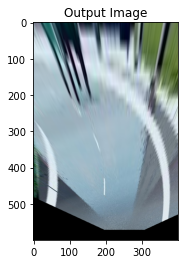

In [4]:
# size of output image
height, width = 600, 400

### START CODE HERE ###

# plot the input image
# cv2.imshow("Input image", img)
# cv2.waitKey(60)
# cv2.destroyAllWindows()

# define the source points
src_pts = np.float32([[344,340], [510, 340], [747, 430], [231, 430]])

# define the destination points 
dst_pts = np.float32([[0.5*width,height*0.7],[0.9*width , height*0.7],[0.9*width,height*0.9],[0.5*width,height*0.9]])

# calculate the perspective transform matrix
P_cam_to_bev = cv2.getPerspectiveTransform(src_pts,dst_pts)
#print (P_cam_to_bev)

# caculate the output image
output = cv2.warpPerspective(img, P_cam_to_bev, (width, height))
### END CODE HERE ###
show_image(output, "Output Image")


In the following, we will draw a trapezoid connecting the source points in the image and apply the calculated transformation to the image again to see how the trapezoid is mapped. 

In [5]:
# function to draw a line
def draw_line(image, pt1, pt2, color=(0,0,255), thickness=5):
    print(pt1, pt2)
    cv2.line(image, pt1.astype(int), pt2.astype(int), color, thickness)
    
# function to draw rectanges:
def draw_rectange(image, pts, color=(0,0,255), thickness=5):
    draw_line(image, pts[0], pts[1], color, thickness)
    draw_line(image, pts[1], pts[2], color, thickness)
    draw_line(image, pts[2], pts[3], color, thickness)
    draw_line(image, pts[3], pts[0], color, thickness)

[344. 340.] [510. 340.]
[510. 340.] [747. 430.]
[747. 430.] [231. 430.]
[231. 430.] [344. 340.]


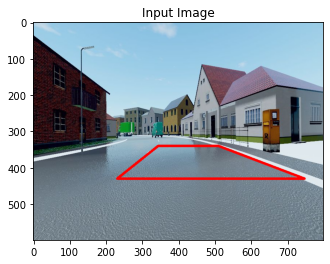

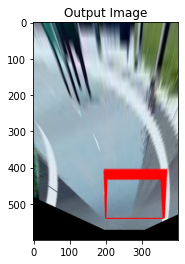

In [6]:
# draw a rectange that shows the source points
draw_rectange(img, src_pts)
# draw a rectangle that shows the destination points
#draw_rectange(output, dst_pts)
# caculate the output image
output =cv2.warpPerspective(img ,P_cam_to_bev, (width,height))


show_image(img, "Input Image")
show_image(output, "Output Image")

This method doesn't only work for mapping images into a BEV. It can map any view into another, as long as the source and destination points are coplanar.  

## IPM using Projective Geometry
As the methood using opencv is not exact (because the source and destination points have to be set manually), a geometry-based method for calculating the bev-image using coordinate system transformations will be discussed.

The geometry-based method will be based on a simple camera model and will use the intrinsic and extrinsic matrices to compute the perspective transformation matrix.


### Camera Model
We will start by introducing the simple camera model we will use in this assignment.
This model defines how a point $\textbf{X}=(X,Y,Z)$ in the world frame gets transformed to a point $\textbf{x}_{cam}=(x_c,y_c)$ in the camera image. 

This model uses intrinsic and extrinsic parameters of the camera. 

#### Transformation from the world frame to the camera frame
Here we **assume** that the **world frame** is the **vehicle's main frame** since our goal is to produce a **vehicle-centered** BEV image or semantic grid map. The main vehicle's coordinate frame is often referred to as the __base link__. It can be used to relate the coordinates of the vehicle to the map coordinates.

We define a homogeneous transformation **E** that transforms points in the world frame to the camera frame (still three-dimensional) as shown in the follwing equation: 

$$ \large X_{cam} = E X $$

where **X** represents the homogeneous coordinate of the (three-dimensinal) point in the world frame (here also the vehicle's main frame) and **X<sub>cam</sub>** represents the homogeneous coordinate of the (three-dimensinal) point in the camera frame. 


This homogeneous transformation matrix incorporates the **extrinsic parameters** of the camera. 
We will refer to this matrix as the **extrinsic matrix**.
It depends on the pose of the camera with respect to a reference frame. In our case, the extrinsic matrix transforms the main vehicle's coordinate frame to the camera coordinate frame.


**E** can be composed of a 3x3 rotation matrix **R** and a 3x1 translation vector **t**.      

$$ \large E = \begin{bmatrix} R & t \\ 0^T & 1\end{bmatrix} = \begin{bmatrix} R & -R \tilde{C} \\ 0^T & 1\end{bmatrix}$$

Where $\tilde{C}$ is the coordinate of the frame in the vehilce's main frame. 

Now that we can map points to the camera frame, we will project them into the image plane.

#### Transformation from the camera frame to the image plane
We define a projective transformation **K** that transforms three-dimensional points in the camera frame coordinates to two-dimensional points in the image coordinates. This transformation can also be defined as a matrix, which depends on the parameters of the camera, like the focal length $f$ and the principal point $p$. (Here, we ignore the lens distortion).
We will refer to this matrix as the **intrinsic matrix**. 
The homogeneous coordinates of a three-dimentional point in the camera frame are mapped to the homogeneous coordinates of two-dimensional point in the image plane according to the following equation:

$$ \large x_{cam} = K [I|0] X_{cam} = K \begin{bmatrix} 1 & 0 & 0 & 0\\ 0 & 1 & 0 & 0 \\ 0 & 0 & 1 & 0\end{bmatrix} X_{cam} $$


where **X<sub>cam</sub>** is the homogeneous coordinates of the (three-dimensinal) point in the camera frame and **x<sub>cam</sub>** is the homogeneous coordinate of the (two-dimentional) point in the camera plane.

**K** can be written as follows:

$$ \large K = \begin{bmatrix} f_x & 0 & p_x \\ 0 & f_y & p_y \\ 0 & 0 & 1\end{bmatrix}$$


### Camera projection matrix
Using the extrinsic and intrinsic transformation matrices, we can define the transformation that maps points in the vehicle's coordinates system to the image plane coordinate system, according to the following equation:

$$ \large x_{cam} = P X$$

The projection matrix **P** can be calculated by multiplying **K** and **E**:  

$$ \large P = K \begin{bmatrix} 1 & 0 & 0 & 0 \\ 0 & 1 & 0 & 0 \\ 0 & 0 & 1 & 0\end{bmatrix} E $$

The matrix is $\large [I | 0]$ is needed since we only need the __inhomogeneous__ coordinates of the point __X__ in the world frame.

## Task: Get the camera intrinsic matrix
Camera parameters are can be estimated by conducting a camera calibration.
Here, the camera calibration was already conducted and the parameters are provided in an external file. 
The goal of this task is to extract these parameters from the external file.

Your task here is to read the intrinsic matrix from a json file.
For this purpose, you will implement a function that gets a path to a JSON file and returns a dictionary containing the intrinsics of all cameras in the file as **NumPy arrays**. 
Complete the function `get_intrinsics()` by replacing the `None` placeholders.
#### __Hints:__
- Inspect the file `intrinsics.json` provided under `ipm_assets/cameras/intrinsics.json`.
- Use python `open()` to read the json file. Refer to the [documentation](https://docs.python.org/3/library/functions.html#open).  
- Use the function `json.load()`. Refer to the [documentation](https://docs.python.org/3/library/json.html).
- after reading the file you should get a dictionary that contains the intrinsic matrix of **8 cameras** mounted on a vehicle. In the json files, the cameras are named: **('vr_1', 'vl_1', 'hr_1', 'hl_1', 'vr_2', 'vl_2', 'hr_2', 'hl_2')**
- Note that loaded matrices are saved as python lists and need to be converted to NumPy arrays


In [7]:
def get_intrinsics(f_path="ipm_assets/cameras/intrinsics.json"):
    ### START CODE HERE ###
    file = open(f_path)
    intrinsics_dict = json.load(file)
    for camera_n, intrinsic_matrix in intrinsics_dict.items():
        intrinsics_dict[camera_n] = np.array(intrinsic_matrix)
    ### END CODE HERE ###
    return intrinsics_dict

intrinsics_dict = get_intrinsics()

The dictionary we loaded contains the intrinsic matrices of 8 different cameras. Let's print the intrinsic matrix of the **front right camera**.

In [8]:
# Get the intrinsics of the first front facing camera (vr_1)
K = np.array(intrinsics_dict['vr_1'])
K

array([[294.20083618,   0.        , 399.81140137],
       [  0.        , 467.5324707 , 299.70028687],
       [  0.        ,   0.        ,   1.        ]])

## Task: Calculate the camera extrinsic matrix
The goal of this task is to compute the extrinsic matrix of the camera.

Your task here is to read the extrinsic camera parameters from a JSON file.
The provided JSON files contain extrinsic information about multiple camera-mounted vehicles. 
This information contains the translation of each camera frame w.r.t the vehicle frame.
It also contains the orientation of each camera frame w.r.t the vehicle frame expressed in roll, pitch yaw angles.

The **position** and **orientation** of the camera need to be converted into a homogeneous transformation. 


The goal here is to implement a function that gets a path to a JSON file and returns a dictionary containing the homogeneous transformations describing the extrinsic parameters of all cameras in the file as NumPy arrays.

Replace the `None` placeholders with your code.
#### __Hints:__
- Read the translation vector (saved in the dictionary as 'translation') and convert it to a NumPy array.
- Read (roll, pitch, yaw) (saved in the dictionary as 'rotation_rpy').
- The representation (`roll`, `pitch`, `yaw`) is equivalent to (3x3)-rotation matrices performing the following operations in order:
    - a rotation around the x-axis with the roll angle
    - a rotation around the y-axis with the pitch angle
    - a rotation around the z-axis with the yaw angle
- Combine into a homogeneous transform (4x4)
    - use [`numpy.column_stack()`](https://numpy.org/doc/stable/reference/generated/numpy.column_stack.html) and [`numpy.row_stack()`](https://numpy.org/devdocs/reference/generated/numpy.row_stack.html)
    - Start by performing a column-wise stacking of the rotation matrix and the translation vector. The result should be a 3x4 matrix,
    - then perform a row-wise stacking of the resulting 3x4 matrix and the array `np.array([0., 0., 0., 1.])`. The result should be a 4x4 matrix. 
    - The result should be a dictionary that contains camera names as keys and their corresponding extrinsic matrices as values. 

In [9]:
import json 
import numpy as np

def get_extrinsics(f_path="ipm_assets/cameras/extrinsics_rpy.json"):
    # read json file
    file = open(f_path)
    extrinsics_rpy_dict = json.load(file)

    # extrinsic dict (here we will save the extrinsic matrix for each camera)
    extrinsics_dict = dict()
    
    for camera_n, extrinsic_params in extrinsics_rpy_dict.items():
        # extract translation parameter
        t = np.array(extrinsic_params["translation"])
        
        # get roll, pitch and yaw for the camera 'camera_n'
        roll, pitch, yaw = extrinsic_params["rotation_rpy"]
        # compute rotation matrix
        Rz = np.array([[np.cos(yaw), -np.sin(yaw), 0],
                       [np.sin(yaw), np.cos(yaw), 0],
                       [0, 0, 1]])
        Ry = np.array([[np.cos(yaw), 0, np.sin(yaw)],
                       [0, 1, 0],
                       [-np.sin(yaw), 0, np.cos(yaw)]])
        Rx = np.array([[1, 0, 0],
                       [0, np.cos(yaw), -np.sin(yaw)],
                       [0, np.sin(yaw), np.cos(yaw)]])
                      
        R = Rz.dot(Ry.dot(Rx))

        # combine translation (3x1) and rotation matrix (3x3) into a 4x4 homogeneous transform
        transform = np.column_stack([R, t])
        # add 1 row ([0., 0., 0., 1.]) to complete the transform 
        transform = np.vstack([transform, np.array([0, 0, 0, 1])])
        extrinsics_dict[camera_n] = transform
        
    return extrinsics_dict

extrinsics_dict = get_extrinsics()


Let's print the extrinsic matrix of the **front right camera**.

In [10]:
# Get the extrinsics of the first front facing camera (vr_1)
E = extrinsics_dict['vr_1']
E


array([[ 1.00000000e+00, -8.57944533e-16,  8.57944533e-16,
        -1.91794571e+00],
       [ 8.57944533e-16,  1.00000000e+00, -8.57944533e-16,
         9.10000000e-01],
       [-8.57944533e-16,  8.57944533e-16,  1.00000000e+00,
        -3.66136563e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00]])

Great! We can now build the complete camera projection model.

## Task: Calculate the projection matrix

Calculate the camera projection matrix of the front right camera by replacing the `None` placeholder with your code.
#### __Hints__:

- The output should be a 3x4 matrix
- The extrinsic matrix is a 4x4 matrix where the intrinsic matrix is a 3x3 matrix, so don't forget the $[I|0]$ matrix
- Remember that we already saved the intrinsic and extrinsic matrices of the front right camera (in `K` and `E`) 



In [14]:
### START CODE HERE ###

I = np.array([[1,0,0,0],[0,1,0,0],[0,0,1,0]])
P = K.dot(I.dot(E))

### END CODE HERE ###
P

array([[ 2.94200836e+02,  9.06080070e-14,  3.99811401e+02,
        -2.02811695e+03],
       [ 1.43990705e-13,  4.67532471e+02,  2.99700287e+02,
        -6.71857780e+02],
       [-8.57944533e-16,  8.57944533e-16,  1.00000000e+00,
        -3.66136563e+00]])

## Task: Mapping from  the road (BEV image) coordinates to the vehicle's coordinates

Now we will define the mapping **M** from (two-dimensional) BEV image plane points (in homogeneous road coordinates) to (three-dimensional) world points (in homogeneous vehicle frame coordinates). 
In its simplest form, the mapping would have the following equation:

$$\large  M_{\text{2Dto3D}} = \begin{bmatrix} 1 & 0 & 0 \\ 0 & 1 & 0 \\ 0 & 0 & 0 \\ 0 & 0 & 1\end{bmatrix} $$


The equaion for $M_{\text{2Dto3D}}$ is based on the assumption that *z<sub>r</sub> = 0* (all points on the road plane have the height zero).

In addition to *z<sub>r</sub> = 0* , this equation also requires that the coordinate system of the road and the vehicle are colocated and have the same orientation. 
Since not all of these conditions are satisfied, we have to adjust M.
The figure below shows that the two frames are not colocated and don't have the same orientation.

![Expected Output](ipm_assets/images/road_to_vehicle.png "OpenCV cooridnates")


#### Parameters

Let's first define some parameters for the mapping **M**. 
- `px_per_m` is the resolution and sets the number of pixels used to draw 1m. This resolution is used vertically and horizontally. In our case, 1px corresponds to 0.1m².
- `output_width` and `output_height` are the dimensions of the BEV image.
- `shift_x` and `shift_y` specify by how much the origin of the vehicle frame is shifted w.r.t the road frame 

In [15]:
# parameters for ipm
# output resolution
px_per_m = 10 # number of pixels per meter
# output size
output_width = 798
output_height = 400
# shift to center of output image
shift_x = output_width/ 2.0 
shift_y = output_height / 2.0

### Add shift operation:

The first adjustment you will have to make to the mapping **M**, from the road coordinates frame to the vehicles coordinates frame, is **shifting** the coordinate frame of the road to the coordinate frame of the vehicle.

For this pupose, **replace** the `None` placeholder with your code to define a homogeneous transformation matrix that performs a translation with (x<sub>shift</sub>, y<sub>shift</sub>) w.r.t the road frame.

##### __Hints__:
- The homogeneous matrix incorporating a translation with (x<sub>shift</sub>, y<sub>shift</sub>) can be written as 


$$ \large M_{\text{shift}} = \begin{bmatrix} 1 & 0 & x_{\text{shift}}\\ 
0 & 1 & y_{\text{shift}} \\ 
0 & 0 & 1 \end{bmatrix} $$




In [16]:
### START CODE HERE ###
M_shift = [[1,0,shift_x],[0,1,shift_y],[0,0,1]]
### END CODE HERE ###


### Change the direction of the y-axis:

The second adjustment you will have to make to the mapping **M** is **mirroring** the coordinate frame of the road on the x-axis such that the y-axis of both frames match.

For this purpose, **replace** the `None` placeholder with your code to define a homogeneous transformation matrix that performs the mirroring.

##### __Hints__:
- With what homogeneous matrix does a homogeneous point **x** = (x,y,1) need to change the sign of y 

$$  \large \begin{bmatrix} x\\ 
-y\\ 
1\end{bmatrix} = M_{\text{direction}}\begin{bmatrix} x\\ 
y\\ 
1\end{bmatrix} $$


In [19]:
### START CODE HERE ###

M_direction = np.array([[1,0,0],[0,-1,0],[0,0,1]])
M_direction

### END CODE HERE ###


array([[ 1,  0,  0],
       [ 0, -1,  0],
       [ 0,  0,  1]])

### Change the scaling of the y-axis:

The second adjustment you will have to make to the mapping **M**, would be **scaling** the coordinates in the road frame. This scaling depends on the specified resolution for the transformation.

For this purpose, **replace** the `None` placeholder with your code to define a homogeneous transformation matrix that performs the scaling.

##### __Hints__:
- A homogeneous transformation that performs scaling of the inputs with the value **a** can be written as:
$$ \large M_{\text{scale}} = \begin{bmatrix} a & 0 & 0\\ 
0 & a & 0 \\ 
0 & 0 & 1 \end{bmatrix} $$

- Remember that the inputs (coordinates in the BEV image) have the unit pixel and the (coordinates in the road) the unit meter 
- Use `px_per_m` for scaling. 

In [20]:
### START CODE HERE ###
a = 1/px_per_m
M_scale = np.array([[a,0,0],[0,0,a],[0,0,1]])

### END CODE HERE ###


### Adjusted transformation M:
The new transformation M combines `M_2Dto3D` and the **shift**, **mirroring** and **scaling** operations needed for the adjustment.

**replace** the `None` placeholder with your code to define the adjusted transformation matrix **M**.

#### __Hints__
- (One) valid order of the operations: shift (`M_shift`), mirroring(`M_direction`), scaling(`M_scale`), then mapping (`M_2Dto3D`)

In [28]:
### START CODE HERE ###
# direct mapping (assuming z=0)

M_2Dto3D = np.array([[1,0,0],[0,1,0],[0,0,1]])
M_2Dto3D
M_scale
M_direction

# adjusted
M = M_2Dto3D.dot(M_scale).dot(M_direction.dot(M_shift))
### END CODE HERE ###

M

array([[1.00e+01, 0.00e+00, 3.99e+03],
       [0.00e+00, 0.00e+00, 1.00e+01],
       [0.00e+00, 0.00e+00, 1.00e+00]])

Now that we have all the needed parts to build a mapping between camera images and the BEV image, we can compute the **inverse perspective mapping matrix**. 

## Task: Calculate the inverse perspective mapping matrix
Calcuate the mapping from the road image to the front camera image, then calculate the inverse matrix, which transforms images from the camera to the road (or top-down) view.

Replace the `None` placeholder with your code.
#### __Hints:__
- the mapping from the road image to the front camera image is defined as follows (we need the **inverse**)

$$ \large x_{cam} = P X = K [I|0] E X= K[R|t] M x_r$$

- __X__ is the coordinate of a point in the vehicle frame
- __x<sub>r</sub>__ is the coordinate of the same point in the road frame
- __x<sub>cam</sub>__ is the coordinate of the same point in image coordinates
- use `numpy.linalg.inv()` (dcoumentation [here](https://numpy.org/doc/stable/reference/generated/numpy.linalg.inv.html)) to invert the matrix

In [ ]:
### START CODE HERE ###

M_ipm = None
### END CODE HERE ###

print(M_ipm) 

## Task: Apply the inverse perspective mapping matrix on one image
Here you will use the matrix M_ipm to apply the perspective mapping.
You can use cv2.warpPerspective() which takes as input an image and a mapping matrix (3x3). 
This function applies the homography matrix to every pixel in the input image.
For every position (x<sub>c</sub>,y<sub>c</sub>) in the input image, (x<sub>r</sub>,y<sub>r</sub>) is calculated.
cv2.warpPerspective(), also applies interpolation.

Replace the `None` placeholder with your code.

#### __Hints:__
- read the image from **"ipm_assets/images/vr_1.png"**. Use [`cv2.imread()`](https://docs.opencv.org/3.4/d4/da8/group__imgcodecs.html)
- use OpenCV's perspective warp function: `cv2.warpPerspective()`
- expected output 

![Expected Output](ipm_assets/images/ipm_invalid.png "ipm output")


In [ ]:
### START CODE HERE ###
# read image
image = None

# use M_ipm to perform the perspective mapping
img_out = None
### END CODE HERE ###

show_image(img_out, "Output")

The mapping we designed doesn't hold for pixels above the ground level.
That is why, e.g., buildings are mapped incorrectly.

You can mitigate this effect by simply masking the upper part of the input image (which doesn't show the road).

Replace the `None` placeholders with your code.


#### __Hints__:
- Define a zero matrix (numpy array) **mask**, that has the height and width of the input image. Use **dtype="uint8"**
- Draw a rectangle on the mask that has the color white=255 and covers the part of the image that we don't want to mask (lower half)
- Use **cv2.bitwise_and(image, image, mask=mask)** to apply the mask to the input
- Expected output: 

![Expected Output](ipm_assets/images/cropped_image.png "Cropped image")

In [ ]:
### START CODE HERE ###

# extract the height and width of the input image 
input_img_height, input_img_width, _ = None
# intialize the mask with np.zeros  
mask = None
# rectangle for the region of intrest
cv2.rectangle(mask, None, None, None,  255, -1)
# apply mask
image = cv2.bitwise_and(image, image, mask=None)

### END CODE HERE ###

# show the image
show_image(image)


## Task: Putting everything together

In order to avoid doing the whole process of calculating the IPM matrix manually for different cameras, we can put everything we did into one function that takes as inputs:

- image
- extrinsic matrix of the camera 
- intrinsic matrix of the camera
- a config dictionary (output height, width, resolution, etc.)

and outputs:
- BEV image

Replace the `None` placeholders with your code.

##### __Hints:__ 
- don't forget to mask the upper half of every input image
- expected output:

![Expected Output](ipm_assets/images/output_expected.png "Cropped image")

In [ ]:
# make sure you have loaded extrinsics_dict, intrinsics_dict
E = extrinsics_dict['vr_1']
K = intrinsics_dict['vr_1']
config = {}
config["px_per_m"] = 10 # number of pixels per meter
config["output_width"] = 798
config["output_height"] = 400
# shift to center of output image
config["shift_x"] = config["output_width"] / 2.0 
config["shift_y"] = config["output_height"] /2.0

In [ ]:
def apply_ipm(image, E, K, config):
    # parameters for ipm
    # output resolution
    px_per_m = config["px_per_m"] 
    # output size
    width = config["output_width"]
    height = config["output_height"]
    # shift to center of the left edge of output image
    shift_x = config["shift_x"]
    shift_y = config["shift_y"]
    
    
    input_img_height, input_img_width, _ = image.shape
    
    ### START CODE HERE ###

    mask = None
    cv2.rectangle(None, None, None,  255, -1)
    image = None
    
    # define matrix that maps from the road frame to the vehicle frame
    
    M_2Dto3D = None
    M_direction = None
    M_shift = None
    M_scale = None
    
    M = None
    
    # define projection matrix
    P = None
    
    M_ipm = None
    
    
    img_out = None
    
    ### END CODE HERE ###

    return img_out

In [ ]:
# read image
img = cv2.imread("ipm_assets/images/vr_1.png")
img = img[:, :, :]

print(img.shape)
# show image 
show_image(img, "Original Image")

# apply ipm
img_out2 = apply_ipm(img, E, K, config)
# show output image 
show_image(img_out2, "Output")


Using a single camera doesn't result in the 360° BEV. We can apply IPM to images from cameras facing different directions and stitch the result in BEV.

## Task: Stitch multiple images in BEV
In this task, you will use images from 8 different cameras.

You will load multiple images from a folder and use the extrinsic and intrinsic camera parameters loaded from the JSON file and use them to apply inverse perspective mapping to the images. 

You will implement a simple stitching strategy: simply add the images from the different cameras in the BEV.  
Replace the `None` placeholders with your code.


#### __Hints:__
- Save images in a dictionary (e.g. `images_dict = {'vr_1': ...}`) with the same key used for the camera parameters
- Create a zeros numpy array that will contain the total BEV image with the shape : `config['output_height'], config['output_width'],3)`
- Iterate over all images: (e.g. `for image_key, image_val in images_dict.items()` ...)
- Add the images to the total image **only at the position that are still** `= [0, 0, 0 ]` (black pixels)
- Black pixels in an image can be isolated using "`image[image==(0,0,0)]`"
- expected output:

![Expected Output](ipm_assets/images/rgb_bev_360.png "RGB BEV")

In [ ]:
# load images from folder
images_directory = "ipm_assets/cameras/images"
images = {}
for filename in os.listdir(images_directory):
    if filename.endswith(".jpg"):
        image_pth = os.path.join(images_directory, filename)
        #print(image_pth)
        images[filename.split('.')[0]] = cv2.imread(image_pth)

In [ ]:
# apply bev and add images 
def apply_ipm_and_stitch_images(images, config, extrinsics_dict, intrinsics_dict):
    ### START CODE HERE ###
    bev_total_img = None
    for n, image in images.items():
        output_image = None
        #show_image(output_image, n)
        bev_total_img[bev_total_img==(0,0,0)] = None
    ### END CODE HERE ###

    show_image(bev_total_img)                     
        
apply_ipm_and_stitch_images(images, config, extrinsics_dict, intrinsics_dict)
        

## Task: Apply IPM to semantically segmented images
The same way we applied IPM to RGB images, we can **apply it to semantically segmented images**. The resulting **BEV images will also be semantically segmented**.

The task here is to perform camera-based semantic grid mapping by using IPM on semantically segmented images.
Here you will use the same approach we used for normal camera images.

Run the two next cells, then replace the `None` placeholders with your code.

#### __Hints__:
- expected output:

![Expected Output](ipm_assets/images/sem_bev_360.png "RGB BEV")

In [ ]:
# get extrinsic matrices dictionary
extrinsics_dict = get_extrinsics(f_path="ipm_assets/carla_data/extrinsics_rpy.json")

intrinsics_dict = get_intrinsics(f_path="ipm_assets/carla_data/intrinsics.json")

In [ ]:
# load images from folder
images_directory = "ipm_assets/carla_data/frames"
images = {}
for filename in os.listdir(images_directory):
    if filename.endswith(".jpg"):
        image_pth = os.path.join(images_directory, filename)
        #print(image_pth)
        images[filename.split('.')[0]] = cv2.imread(image_pth)
# list all images names in the dictionary "images"       
print(images.keys())

# show front right image 
show_image(images['front_right_1'])

In [ ]:
### START CODE HERE ###        

apply_ipm_and_stitch_images(None, None, None, None)

### END CODE HERE ###

## Wrap Up

- You learned how to apply inverse perspective mapping using opencv.
- You learned how to apply inverse perspective mapping using the camera model and coordinate transformations.
- You learned how to stitch multiple images in bird's-eye-view.
- You learned how to compute a geometry-based semantic grid mapping.

## License


MIT License

Copyright 2023 Institute for Automotive Engineering of RWTH Aachen University.